In [1]:
import os
import torch
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

device = 'cuda' if torch.cuda.is_available() else 'cpu'


In [2]:
%matplotlib inline
import numpy as np
import sigpy as sp
import sigpy.mri as mr
import sigpy.plot as pl
import matplotlib.pyplot as plt
from scipy.io import loadmat, savemat
from scipy import fft, fftpack
from random import randrange
import re
import importlib

import h5py
from scipy.ndimage import zoom

# functions for metrics adapted from .py file provided by Efrat
from metrics import calc_NRMSE as nrmse
from metrics import calc_SSIM as ssim

from ulf_recon_fns import ulfl1recon, applyMask, poissonDiscSigpy, find_lamda_mask, find_iter_mask, coil_combine, awgn
import display_fns

import automap_fns #import automapRecon
import unrolling_fns
import swin_fns

2026-01-13 11:53:38.203317: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-01-13 11:53:39.355625: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/david/repos/lowfieldrecon/LowFieldReconPrivate/.venvkerasandtf/lib/python3.10/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


## Importing Phantom Data

In [3]:
filename = 'data/phantom_data_75_64_25_2.mat'
data = loadmat(filename)

In [4]:
kspGT = np.moveaxis(data['i_kspace_NA256'],3,0)

In [5]:
kspGT = kspGT[0,:,:,:]+1j*kspGT[1,:,:,:]
kspGT = kspGT[np.newaxis,:]

## Scaling data

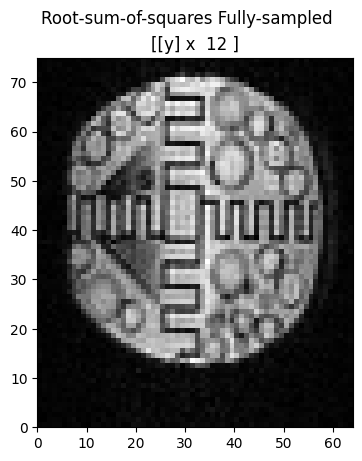

In [6]:
# stock standard recon to get an appropriate scaling factor for the ksp data
img_rss = np.sum(np.abs(sp.ifft(kspGT, axes=(-1, -2, -3)))**2, axis=0)**0.5
volumeGTrss = img_rss

pl.ImagePlot(img_rss, x=1,y=0,title='Root-sum-of-squares Fully-sampled')

# scaling all numbers to sensible values from the beginning
scale_factor = np.percentile(abs(volumeGTrss),95) 
kspGTscaled = kspGT/scale_factor

yshift = -2
kspGTscaled = np.roll(kspGTscaled,(0,yshift,0),axis=(1,2,3))

#kspNA32scaled = kspGTscaled

kspNA256scaled = np.moveaxis(data['i_kspace_NA256'],3,0)/scale_factor*8
kspNA256scaled = np.roll(kspNA256scaled,(0,yshift,0),axis=(1,2,3))

kspNA32scaled = np.moveaxis(data['i_kspace_NA32'],3,0)/scale_factor*256/32
kspNA32scaled = np.roll(kspNA32scaled,(0,yshift,0),axis=(1,2,3))

kspNA16scaled = np.moveaxis(data['i_kspace_NA16'],3,0)/scale_factor*256/16
kspNA16scaled = np.roll(kspNA16scaled,(0,yshift,0),axis=(1,2,3))

kspNA8scaled = np.moveaxis(data['i_kspace_NA8'],3,0)/scale_factor*256/8
kspNA8scaled = np.roll(kspNA8scaled,(0,yshift,0),axis=(1,2,3))

kspNA4scaled = np.moveaxis(data['i_kspace_NA4'],3,0)/scale_factor*256/4
kspNA4scaled = np.roll(kspNA4scaled,(0,yshift,0),axis=(1,2,3))

if kspGTscaled.shape[0] == 1:
    mps = np.ones(kspGTscaled.shape,dtype=complex)
else:
    mps = mr.app.EspiritCalib(kspGTscaled, calib_width=20, kernel_width=6, show_pbar=True).run()
    #mps = mr.app.JsenseRecon(kspGTscaled, ksp_calib_width=20, mps_ker_width=6, show_pbar=True).run()
#mps = np.ones(kspGTscaled.shape)
img_fs = sp.ifft(kspGTscaled, axes=(-1, -2, -3))
volumeGTscaled = coil_combine(img_fs,mps)

In [7]:
mask_metrics = np.ma.getmask(np.ma.masked_less(abs(volumeGTscaled),0.15))

volumeGTscaledmasked = np.copy(volumeGTscaled)
volumeGTscaledmasked[mask_metrics]=0

kspTestScaled = kspNA32scaled #kspGTscaled

#optional recentering of k-space to correct phase map
delta_x = 0
delta_y = 0
delta_z = 0
kspTestScaled = np.roll(kspTestScaled,(delta_x,delta_y,delta_z),axis=(1,2,3)) 

## Input data

## R=2 Calcs

In [8]:
R = 2 # acceleration factor
calib_size = 10

loss_fn = 'mse'
#loss_fn = 'perceptual'


In [9]:
if R==2:
    unroll_model_pth = 'trained_models/Unrolling/Unroll_mse_R2.pth'
    model_real_dir = 'trained_models/AUTOMAP/train_25x75_fmri-hcp_r2_real_noise_bkgd_20240318/checkpoint/model.keras' #fast mri model
    model_imag_dir = 'trained_models/AUTOMAP/train_25x75_fmri-hcp_r2_imag_noise_bkgd_20240318/checkpoint/model.keras'
    model_swin_pth = 'trained_models/SwinCascade/swincascade_model_best_R2.pth'
    
elif R==4:
    unroll_model_pth = 'trained_models/Unrolling/Unroll_mse_R4.pth'
    model_real_dir = 'trained_models/AUTOMAP/train_25x75_fmri-hcp_r4_real_noise_bkgd_20240328/checkpoint/model.keras' #fast mri model
    model_imag_dir = 'trained_models/AUTOMAP/train_25x75_fmri-hcp_r4_imag_noise_bkgd_20240328/checkpoint/model.keras'
    model_swin_pth = 'trained_models/SwinCascade/swincascade_model_best_R4.pth'

### Poisson Disc Mask

In [10]:

# defining PD mask
imSize = np.array(img_rss.shape)

in_seed = 0#randrange(100)
if R==1:
  mask = poissonDiscSigpy(imSize,R, in_seed,calib_size)  
elif R==2:
  mask = poissonDiscSigpy(imSize,R, in_seed,calib_size)
elif R==4:
  mask = poissonDiscSigpy(imSize,R+0.5, in_seed,calib_size)  
mask.shape

1/np.mean(abs(mask)) #true R value


1.9389865563598758

In [11]:
mask.shape

(75, 25)

## Masking and Reconstructing Data

In [12]:
#kspInput = kspGTscaled

#kspInput = kspNA32scaled
kspInput = kspNA16scaled
kspInput = kspInput[0,:,:,:]+1j*kspInput[1,:,:,:]
kspInput = kspInput[np.newaxis,:]
NAstr = ' '


In [13]:
uskspace = applyMask(kspInput,mask)

In [14]:
importlib.reload(unrolling_fns)
importlib.reload(swin_fns)

import time

no_masks = 1

lamda_opt=0.05
iter_opt=10

#lamda_opt = find_lamda_mask(uskspace, volumeGTscaled, mps,calib_size, show_plot=False)
#iter_opt = find_iter_mask(uskspace,volumeGTscaled, lamda_opt, mps, show_plot=False)


start_time = time.time()
volcsrecon = ulfl1recon(uskspace,mask,lamda_opt,iter_opt,mps)
print(f"CS recon time: {time.time() - start_time:.2f} s")

volifftrecon_mc = sp.ifft(uskspace,axes=[1,2,3])
volifftrecon = coil_combine(volifftrecon_mc,mps)# np.sqrt(np.sum(np.abs(volifftrecon_mc)**2,axis=0)).reshape(imSize)

uskspace = np.roll(kspInput,(0,0,0),axis=(1,2,3)) 
uskspace = applyMask(uskspace,mask)

start_time = time.time()
_, volunrollrecon = unrolling_fns.unrollingRecon(uskspace,mask,mps,unroll_model_pth)
print(f"Unroll recon time: {time.time() - start_time:.2f} s")

start_time = time.time()
volamaprecon, volamaprecon_mc = automap_fns.automapRecon(uskspace,mps,model_real_dir,model_imag_dir)
print(f"Amap recon time: {time.time() - start_time:.2f} s")

start_time = time.time()
model_swin = swin_fns.load_swincascade_model(model_swin_pth, device=device)
volswinrecon, _ = swin_fns.swinRecon(uskspace, mask, model_swin, device=device)
print(f"Swin Cascade recon time: {time.time() - start_time:.2f} s")

CS recon time: 1.47 s
Unroll recon time: 3.34 s


2026-01-13 11:53:49.760638: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2026-01-13 11:53:49.760679: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:134] retrieving CUDA diagnostic information for host: autobeast
2026-01-13 11:53:49.760686: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:141] hostname: autobeast
2026-01-13 11:53:49.760789: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:165] libcuda reported version is: 580.95.5
2026-01-13 11:53:49.760815: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:169] kernel reported version is: 575.64.3
2026-01-13 11:53:49.760821: E external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:251] kernel version 575.64.3 does not match DSO version 580.95.5 -- cannot find working devices in this configuration


Amap recon time: 3.02 s


/home/david/repos/lowfieldrecon/LowFieldReconPrivate/.venvkerasandtf/lib/python3.10/site-packages/torch/functional.py:554: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4314.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Swin Cascade recon time: 1657.96 s


## NEX 256 and NEX 16 as references for NEX 16 Data

In [15]:
volumeGTscaled_NA256 = np.copy(volumeGTscaled)
volumeGTscaledmasked_NA256 = np.copy(volumeGTscaled)
volumeGTscaledmasked_NA256[mask_metrics]=0
vol1 = np.copy(volifftrecon)#np.ma.masked_array(volifftrecon, mask = mask_metrics)
vol1[mask_metrics]=0
vol1title = 'Zero-filled IFFT\nNA = 16'+NAstr+'\nR = '+str(R)
vol2 = np.copy(volcsrecon)
vol2[mask_metrics]=0
vol2title = 'Compressed Sensing\nNA = '+NAstr+'\nR = '+str(R)
vol3 = np.copy(volamaprecon)#np.ma.masked_array(volifftrecon, mask = mask_metrics)
vol3[mask_metrics]=0
vol3title = 'AUTOMAP\nNA = '+NAstr+'\nR = '+str(R)
vol4 = np.copy(volunrollrecon)
vol4[mask_metrics]=0
vol4title = 'Unrolling\nNA = '+NAstr+'\nR = '+str(R)
vol5 = np.copy(volswinrecon)
vol5[mask_metrics]=0
vol5title = 'Swin\nNA = '+NAstr+'\nR = '+str(R)

vol1_R2 = vol1
vol2_R2 = vol2
vol3_R2 = vol3
vol4_R2 = vol4
vol5_R2 = vol5

slc = 17

In [16]:
volumeGTscaled_NA16 = np.copy(sp.ifft(kspInput[0,:,:,:],axes=[1,2,3]))
volumeGTscaledmasked_NA16 = np.copy(volumeGTscaled_NA16)
volumeGTscaledmasked_NA16[mask_metrics]=0

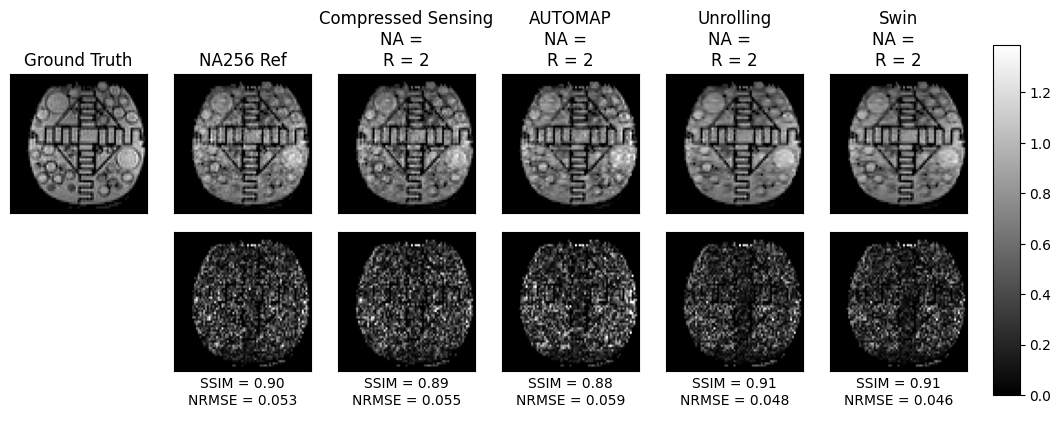

Difference Maps are scaled by 3


In [17]:
import importlib
import display_fns  # or your full module path if needed, e.g., pt_Unrolling.SwinCascade.swin_recon_3d

importlib.reload(display_fns)

from display_fns import compare_n_plot

fig_comp = compare_n_plot(
    GT=volumeGTscaledmasked_NA256,
    volumes=[vol1_R2, vol2_R2, vol3_R2, vol4_R2, vol5_R2],
    titles=['NA256 Ref', vol2title, vol3title, vol4title, vol5title],
    slc=slc,
    scale_err=3
)

#fig_comp.savefig('export_figs/hidden_noise_NA256.pdf', bbox_inches='tight', dpi=300)

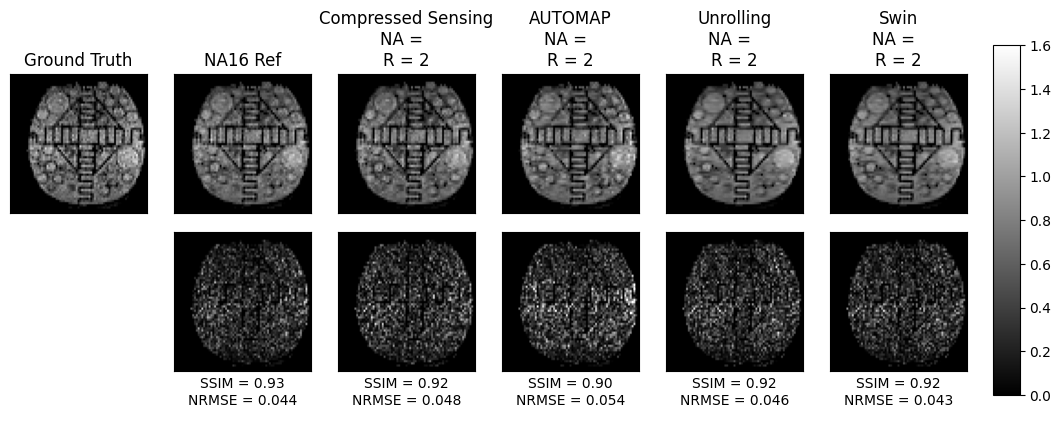

Difference Maps are scaled by 3


In [18]:
fig_comp = compare_n_plot(
    GT=volumeGTscaledmasked_NA16,
    volumes=[vol1_R2, vol2_R2, vol3_R2, vol4_R2, vol5_R2],
    titles=['NA16 Ref', vol2title, vol3title, vol4title, vol5title],
    slc=slc,
    scale_err=3
)

In [19]:
from metrics import brisque_volume_3d, tenengrad_volume_3d

print("\n--- Reference-independent Perceptual Quality (BRISQUE; lower = better) ---")
print(f"BRISQUE (Zero-fill):           {brisque_volume_3d(volifftrecon, axis=2, clip_percentiles=(10,90))[0]:.2f}")
print(f"BRISQUE (Compressed Sensing):  {brisque_volume_3d(volcsrecon, axis=2, clip_percentiles=(10,90))[0]:.2f}")
print(f"BRISQUE (AUTOMAP):             {brisque_volume_3d(volamaprecon, axis=2, clip_percentiles=(10,90))[0]:.2f}")
print(f"BRISQUE (Unrolled Network):    {brisque_volume_3d(volunrollrecon, axis=2, clip_percentiles=(10,90))[0]:.2f}")
print(f"BRISQUE (Swin Transformer):    {brisque_volume_3d(volswinrecon, axis=2, clip_percentiles=(10,90))[0]:.2f}")

print("\n--- Reference-independent Sharpness (Tenengrad; higher = sharper) ---")
print(f"Tenengrad (Zero-fill):           {tenengrad_volume_3d(volifftrecon,       axis=2)[0]:.4f}")
print(f"Tenengrad (Compressed Sensing):  {tenengrad_volume_3d(volcsrecon,         axis=2)[0]:.4f}")
print(f"Tenengrad (AUTOMAP):             {tenengrad_volume_3d(volamaprecon,       axis=2)[0]:.4f}")
print(f"Tenengrad (Unrolled Network):    {tenengrad_volume_3d(volunrollrecon,     axis=2)[0]:.4f}")
print(f"Tenengrad (Swin Transformer):    {tenengrad_volume_3d(volswinrecon,       axis=2)[0]:.4f}")


--- Reference-independent Perceptual Quality (BRISQUE; lower = better) ---
BRISQUE (Zero-fill):           55.36
BRISQUE (Compressed Sensing):  38.66
BRISQUE (AUTOMAP):             54.26
BRISQUE (Unrolled Network):    32.05
BRISQUE (Swin Transformer):    36.51

--- Reference-independent Sharpness (Tenengrad; higher = sharper) ---
Tenengrad (Zero-fill):           0.0176
Tenengrad (Compressed Sensing):  0.0189
Tenengrad (AUTOMAP):             0.0186
Tenengrad (Unrolled Network):    0.0219
Tenengrad (Swin Transformer):    0.0221
